In [1]:
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as pl
import itertools
import scipy.optimize as so


%matplotlib inline

/usr/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [82]:
train = pd.read_csv("train.tsv")
train.drop(["f{}".format(i) for i in range(31, 61)], axis=1, inplace=True)
main_features = ["f{}".format(i) for i in range(1, 31)]
target = 'y'

In [83]:
ID_dict = {}
for i in train["item_id"].values:
    ID_dict[i] = True
IDs = list(ID_dict.keys())

In [84]:
ID_indexes = {}
for i, ID in enumerate(IDs):
    ID_indexes[ID] = i

In [90]:
indexes = [[[[[] for w in range(286)] for k in range(3)] for j in range(53)] for i in range(4)]
for i in range(len(train['year'])):
    (indexes[train['year'].values[i] - 2012]
     [train['week'].values[i] - 1]
     [train['shift'].values[i] - 1]
     [ID_indexes[train['item_id'].values[i]]].append(i))

In [92]:
def MAE(x, A, b):
    result = 0
    for row, b_i in zip(A, b):
        result += abs(np.dot(x, row) - b_i)
    return result

koefs = np.zeros([4, 53, 3, 286, 30])
for year in range(4):
    for week in range(53):
        for shift in range(3):
            for ind_ID in range(286):
                if len(indexes[year][week][shift][ind_ID]) > 0:
                    x_val = [i for i in train[main_features].values[indexes[year][week][shift][ind_ID]]]
                    y_val = train['y'].values[indexes[year][week][shift][ind_ID]]
                    koefs[year, week, shift, ind_ID] = so.minimize(lambda x: MAE(x, x_val, y_val),
                                                           np.ones(30)).x

KeyboardInterrupt: 

In [63]:
week = 4
year = 1
shift = 0
target_data = train['y'].values[indexes[year][week][shift]]
pred = prediction(train, indexes[year][week][shift])
print(SMPAE(pred, target_data), len(pred), len(target_data))

45.435045621 232 232


In [ ]:
for i, j in zip(pred, target_data):
    print(i, j)

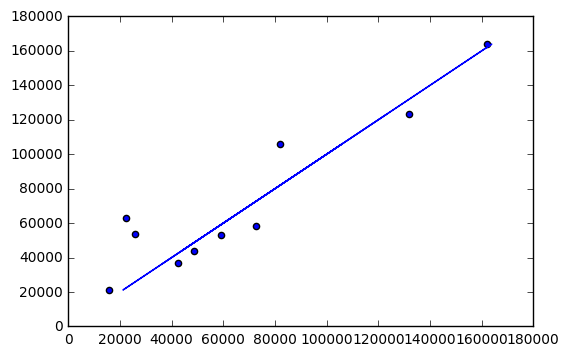

In [61]:
pl.scatter(pred[:10], target_data[:10])
pl.plot(target_data[:10], target_data[:10])

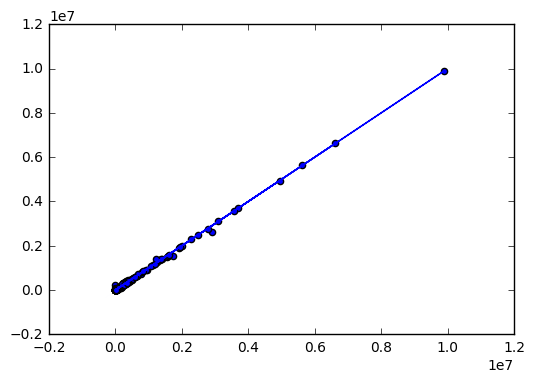

In [52]:
week = 51
year = 0
shift = 0
ind_ID = 0
y = train['y'].values[indexes[year][week][shift][ind_ID]]
x1 = [np.dot(koefs[year, week, shift, ind_ID], i) for i in train[main_features].values[indexes[year][week][shift]]]
x2 = y
pl.scatter(x1, y)
pl.plot(x2, y)

In [55]:
def prediction(X, indexes=None):
    if indexes is None:
        indexes = range(len(X))
    answer = []
    for i in indexes:
        year, week, shift = X[['year', 'week', 'shift']].values[i]
        answer.append(np.dot(koefs[year - 2012, week - 1, shift - 1], X[main_features].values[i]))
    return answer

In [47]:
def SMPAE(pred, y):
    result = 0
    for ans, right_ans in zip(pred, y):
        result += abs(ans - right_ans) / (abs(right_ans) + abs(ans))

    return result * 200 / len(pred)

In [44]:
pred = prediction(train)

In [70]:
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
sample_submission['y'] = prediction(test)
sample_submission.to_csv("submission2.tsv", sep=',', index=False)